Import Packages

In [1]:
import skgstat as skg
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from pprint import pprint
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
import pymc as pm

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Import Data
Source:
Morlighem, M., et al. “BedMachine v3: Complete Bed Topography and Ocean Bathymetry Mapping of Greenland From Multibeam Echo Sounding Combined With Mass Conservation.” Geophysical Research Letters, vol. 44, no. 21, American Geophysical Union (AGU), Nov. 2017, pp. 11,051–11,061, doi:10.1002/2017gl074954.

View Data

Dimensions: 488106x3
          X          Y     Bed
0 -220370.0 -1650000.0  238.31
1 -220370.0 -1650200.0  237.84
2 -220370.0 -1650300.0  234.70
3 -220370.0 -1650400.0  224.55
4 -220370.0 -1650600.0  212.69

X range:              [-300000.0, -150000.0]
Y range:              [-1800000.0, -1650000.0]
Bed elevation range:  [-717.78, 658.558]



AttributeError: module 'matplotlib.pyplot' has no attribute 'set_facecolor'

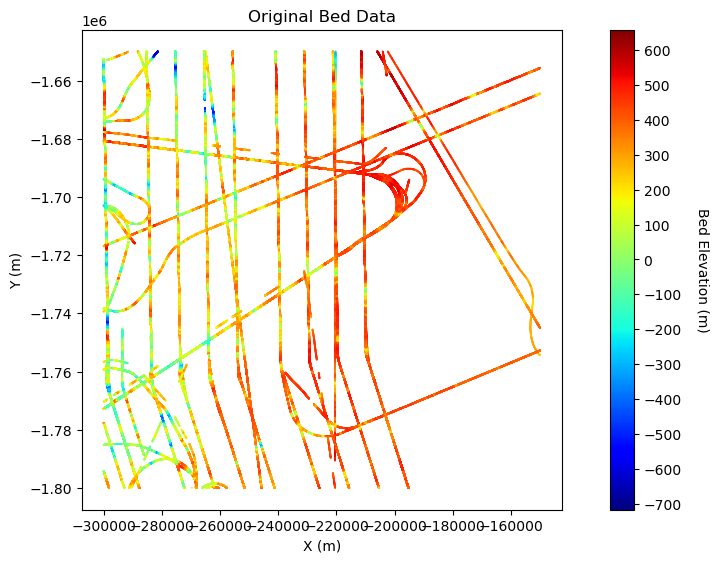

In [2]:
bed_data = pd.read_csv('greenland_test_data.csv')
data_points_count, column_count = bed_data.shape

print(f"Dimensions: {data_points_count}x{column_count}")
print(bed_data.head())
print()

outliers = bed_data['Bed'] > 750
bed_data = bed_data[outliers == 0]

x_min, y_min, bed_elevation_min = bed_data.min()
x_max, y_max, bed_elevation_max = bed_data.max()

print(f"X range:              [{x_min}, {x_max}]")
print(f"Y range:              [{y_min}, {y_max}]")
print(f"Bed elevation range:  [{bed_elevation_min}, {bed_elevation_max}]")
print()

im = plt.scatter(bed_data['X'],bed_data['Y'],
                 c = bed_data['Bed'],
                 vmin = bed_elevation_min, vmax = bed_elevation_max,
                 marker=".", s = 0.5, cmap = 'jet')
plt.title('Original Bed Data')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
cbar = plt.colorbar(im, orientation="vertical", ticks=np.linspace(-800, 700, 16))
cbar.set_label("Bed Elevation (m)", rotation=270, labelpad=20)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0)
plt.axis('scaled')
plt.set_facecolor("yellow")
plt.show

Simulated Annealing Anisotropy Detection:

In [48]:
def calculate_anisotropy(data, square_length, x, y, sample_size, temp = 50, n = 100, cooling_rate = 0.999):
    """
    :param data: nx3 array consisting of X coordinates, Y coordinates, and bed elevation
    :param square_length: Length of the square in which variance is being calculated
    :param x: Top left x coordinate of the square
    :param y: Top left y coordinate of the square
    :param sample_size: Number of datapoints to include in the variogram
    :param temp: Temperature parameter for simulated annealing algorithm
    :param n: Number of simulated annealing iterations
    :param cooling_rate: Cooling rate parameter of simulated annealing
    :return: Azimuth angle of anisotropy
    """

    def directional_variogram(angle):
        """
        :param angle: Azimuth angle of directional variogram
        :return: Integral under variogram from 0 to square_length / 2
        """
        # x <= X < x + square_length
        filtered_data = data[(data['X'] >= x) & (data['X'] < x + square_length)]

        # y - square_length < Y <= y
        filtered_data = filtered_data[(filtered_data['Y'] <= y) & (filtered_data['Y'] > y - square_length)]

        #Sample Data
        if len(filtered_data) > sample_size:
            filtered_data = filtered_data.sample(n = sample_size)

        elif len(filtered_data) < 30:
            return 0

        # Convert data to coordinates and elevations
        elevations = np.array(filtered_data['Bed'])
        elevation_mean = np.mean(elevations)
        coordinates = filtered_data.to_numpy()
        coordinates = coordinates[:,:2]

        n_lags = 100
        maxlag = square_length

        try:
            variogram = skg.DirectionalVariogram(coordinates, elevations, azimuth = angle,
                                             bin_func='even',
                                             n_lags = n_lags, maxlag = maxlag)
        except:
            return 0

        x1 = variogram.bins
        y1 = variogram.experimental
        bin_size = x1[0]

        square_integral = 0
        for i in range(len(x1) // 2):
            square_integral += bin_size * y1[i]

        if square_integral == np.nan:
            for i in range(len(y1)):
                print(y1[i])

        return square_integral

    def SA(search_space, func, T, n, cooling_rate):
        scale = np.sqrt(T)
        x = np.random.choice(search_space)
        cur = func(x)
        history = [x]
        history_y = [cur]

        for i in range(n):
            prop = x + np.random.normal() * scale
            if prop > 180:
                prop -= 180
            elif prop < 0:
                prop += 180
            if np.log(np.random.rand()) * T < (func(prop) - cur):
                prop = x
            x = prop
            cur = func(x)
            T = cooling_rate * T
            history.append(x)
            history_y.append(cur)

        return history, history_y

    X = np.linspace(0, 180, num = 180)

    hist, hist_y = SA(X, directional_variogram, temp, n, cooling_rate)

    plt.scatter(hist, hist_y, s = 0.5)
    plt.xlim(0,180)
    return hist[-1]

In [40]:
def iterate_anisotropy(data, square_length, stride, sample = 300):
    """
    :param sample: Number of datapoints to sample per square
    :param data: nx3 array consisting of X coordinates, Y coordinates, and bed elevation
    :param square_length: Length of the squares in which variance is being calculated
    :param stride: Distance the square shifts after each iteration
    :return: prints quiver plot of anisotropy across topography data
    """

    def directional_variogram(angle):
        """
        :param angle: Azimuth angle of directional variogram
        :return: Integral under variogram from 0 to square_length / 2
        """
        # x <= X < x + square_length
        filtered_data = data[(data['X'] >= x) & (data['X'] < x + square_length)]

        # y - square_length < Y <= y
        filtered_data = filtered_data[(filtered_data['Y'] <= y) & (filtered_data['Y'] > y - square_length)]

        #Sample Data
        if len(filtered_data) > sample:
            filtered_data = filtered_data.sample(n = sample)

        elif len(filtered_data) < 30:
            return 0

        # Convert data to coordinates and elevations
        elevations = np.array(filtered_data['Bed'])
        elevation_mean = np.mean(elevations)
        coordinates = filtered_data.to_numpy()
        coordinates = coordinates[:,:2]

        n_lags = 100
        maxlag = square_length

        try:
            variogram = skg.DirectionalVariogram(coordinates, elevations, azimuth = angle,
                                                 bin_func='even',
                                                 n_lags = n_lags, maxlag = maxlag)
        except:
            return 0


        x1 = variogram.bins
        y1 = variogram.experimental
        bin_size = x1[0]

        square_integral = 0
        for i in range(len(x1) // 2):
            square_integral += bin_size * y1[i]

        if square_integral == np.nan:
            for i in range(len(y1)):
                print(y1[i])

        return square_integral



    #Calculate the range of the data
    x_minimum, y_minimum, _ = data.min()
    x_maximum, y_maximum, _ = data.max()

    #Initialize x and y
    x, y = x_minimum, y_maximum

    #Count squares
    total_x_squares = math.ceil((x_maximum - x_minimum - square_length) / stride) + 1
    total_y_squares = math.ceil((y_maximum - y_minimum - square_length) / stride) + 1
    total_squares = int(total_y_squares * total_x_squares)

    x_center = np.zeros(total_squares)
    y_center = np.zeros(total_squares)

    #Create vector arrays to store anisotropy from each square
    u_1 = np.zeros(total_squares)
    u_2 = np.zeros(total_squares)
    v_1 = np.zeros(total_squares)
    v_2 = np.zeros(total_squares)

    #Iterate over all data
    i = 0
    while y - square_length >= y_minimum:
        while x + square_length <= x_maximum:

            #Calculate anisotropy
            anisotropy = calculate_anisotropy(data, square_length, x, y, sample)
            x_center[i] = x + square_length / 2.0
            y_center[i] = y - square_length / 2.0

            #Convert to vector
            anisotropy = anisotropy * math.pi / 180

            m1 = directional_variogram(anisotropy + 90)
            m2 = directional_variogram(anisotropy)
            magnitude = 0

            if m2 != 0:
                magnitude = m1 / m2

            u_1[i] = -math.cos(anisotropy) * magnitude
            u_2[i] = math.cos(anisotropy) * magnitude
            v_1[i] = math.sin(anisotropy) * magnitude
            v_2[i] = -math.sin(anisotropy) * magnitude

            i += 1

            #Go to next square
            x += stride

        #Include right edge squares
        if ((x_maximum - x_minimum - square_length) % stride) != 0:
            x = x_maximum - square_length

            #Calculate anisotropy
            anisotropy = calculate_anisotropy(data, square_length, x, y, sample)

            #Convert to vector
            anisotropy = anisotropy * math.pi / 180

            m1 = directional_variogram(anisotropy + 90)
            m2 = directional_variogram(anisotropy)
            magnitude = 0

            if m2 != 0:
                magnitude = m1 / m2

            u_1[i] = -math.cos(anisotropy) * magnitude
            u_2[i] = math.cos(anisotropy) * magnitude
            v_1[i] = math.sin(anisotropy) * magnitude
            v_2[i] = -math.sin(anisotropy) * magnitude

            i += 1


        #Reset x and lower y value to iterate vertically
        x = x_minimum
        y -= stride

    #Include bottom edge squares
    if (y_maximum - y_minimum - square_length) % stride != 0:
        y = y_minimum + square_length
        while x + square_length <= x_maximum:

            #Calculate anisotropy
            anisotropy = calculate_anisotropy(data, square_length, x, y, sample)

            #Convert to vector
            anisotropy = anisotropy * math.pi / 180

            m1 = directional_variogram(anisotropy + 90)
            m2 = directional_variogram(anisotropy)
            magnitude = 0

            if m2 != 0:
                magnitude = m1 / m2

            u_1[i] = -math.cos(anisotropy) * magnitude
            u_2[i] = math.cos(anisotropy) * magnitude
            v_1[i] = math.sin(anisotropy) * magnitude
            v_2[i] = -math.sin(anisotropy) * magnitude

            i += 1

            #Go to next square
            x += stride

        #Include right edge squares
        if ((x_maximum - x_minimum - square_length) % stride) != 0:
            x = x_maximum - square_length

            #Calculate anisotropy
            anisotropy = calculate_anisotropy(data, square_length, x, y, sample)

            #Convert to vector
            anisotropy = anisotropy * math.pi / 180

            m1 = directional_variogram(anisotropy + 90)
            m2 = directional_variogram(anisotropy)
            magnitude = 0

            if m2 != 0:
                magnitude = m1 / m2

            u_1[i] = -math.cos(anisotropy) * magnitude
            u_2[i] = math.cos(anisotropy) * magnitude
            v_1[i] = math.sin(anisotropy) * magnitude
            v_2[i] = -math.sin(anisotropy) * magnitude

            i += 1


    minmax_scale = preprocessing.MinMaxScaler(feature_range=(-1, 1))
    u1_scaled = minmax_scale.fit_transform(u_1.reshape(-1, 1))
    u2_scaled = minmax_scale.fit_transform(u_2.reshape(-1, 1))
    v1_scaled = minmax_scale.fit_transform(v_1.reshape(-1, 1))
    v2_scaled = minmax_scale.fit_transform(v_2.reshape(-1, 1))

    #print(pd.DataFrame({'u1': u1_scaled[:,0], 'v1': v1_scaled[:,0], 'u2':u2_scaled[:,0], 'v2':v2_scaled[:,0]}).to_string())

    plt.figure(figsize = (8,8))
    plt.quiver(x_center, y_center, u1_scaled, v1_scaled)
    plt.quiver(x_center, y_center, u2_scaled, v2_scaled)
    plt.title("Anisotropy")

/Users/calebkoresh/opt/anaconda3/lib/python3.9/site-packages/skgstat/DirectionalVariogram.py:390: RuntimeWarning: invalid value encountered in divide
  pos_angles = np.arccos(scalar / self._euclidean_dist)
/Users/calebkoresh/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/calebkoresh/opt/anaconda3/lib/python3.9/site-packages/skgstat/Variogram.py:1887: RuntimeWarning: All-NaN slice encountered
  bounds = [np.nanmax(x), np.nanmax(y)]
/Users/calebkoresh/opt/anaconda3/lib/python3.9/site-packages/skgstat/binning.py:37: RuntimeWarning: All-NaN slice encountered
  if maxlag is None or maxlag > np.nanmax(distances):


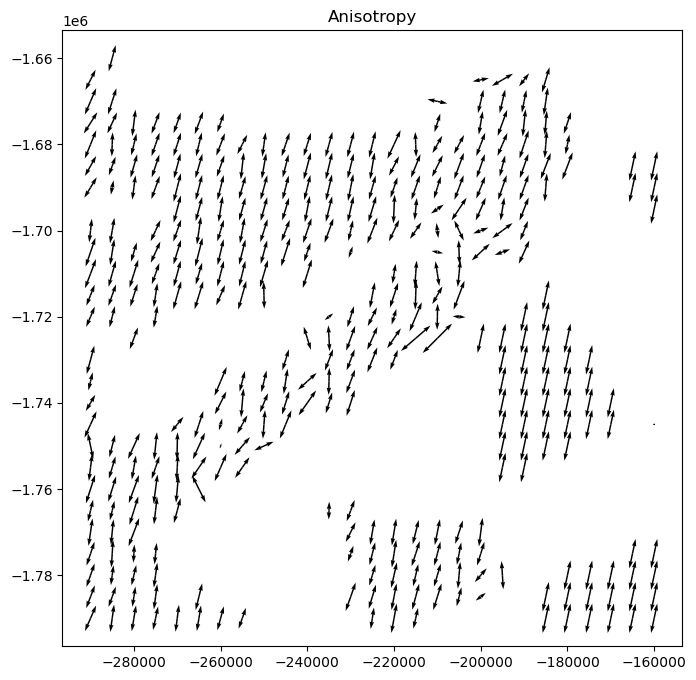

In [42]:
iterate_anisotropy(bed_data, 20000, 5000, sample = 300)